# Mini Project 1

Tori Grosskopf

In this code, I modified the training parameters of the hybrid model to see what was more impactful on the loss curve and r^2 values.

Here is the link to the updated .yaml file, where I have modified the optimization, patience, and dropout rates of the model, and added an additional convolutional layer.

In [ ]:
%matplotlib inline

## Configuring

The configuration for this model training follows the outline given by the EUGENe tutorial, and this model is implemented with the EUGENe dataset.

In [162]:
# Import EUGENe and connect to drive
import os
#!pip install 'eugene-tools' #needs to be commented and uncommented for initial run
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/MyDrive/EUGENe")
cwd = os.getcwd()
cwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/content/drive/MyDrive/EUGENe'

In [163]:
# Configure EUGENe directories
from eugene import settings
settings.config_dir = "./tutorial_configs" # Directory to specify when you want to load a model from a config file
settings.dataset_dir = "./tutorial_dataset" # Directory where EUGENe will download datasets to
settings.logging_dir = "./tutorial_logs" # Directory where EUGENe will save Tensorboard training logs and model checkpoints to
settings.output_dir = "./tutorial_output" # Directory where EUGENe will save output files to
settings.figure_dir = "./tutorial_figures" # Directory to specify to EUGENe to save figures to

## Dataloading
Loading in of EUGENe data sets!


In [164]:
# Import data
import seqdatasets

In [165]:
# Download the Jores dataset to the dataset directory (promoters assayed in leaf promoters).
sdata = seqdatasets.jores21(dataset="leaf")
sdata

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.
Zarr file found. Opening zarr file.


<xarray.Dataset>
Dimensions:     (_sequence: 72158, _length: 170)
Dimensions without coordinates: _sequence, _length
Data variables:
    enrichment  (_sequence) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    gene        (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    seq         (_sequence, _length) |S1 dask.array<chunksize=(1000, 170), meta=np.ndarray>
    set         (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>
    sp          (_sequence) object dask.array<chunksize=(1000,), meta=np.ndarray>

## Data Visualization
Here, we are looking at the targets across different species the promoters were derived from.

In [166]:
from eugene import plot as pl

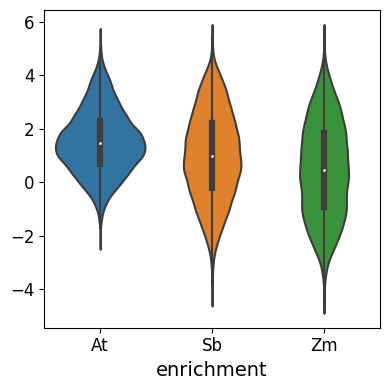

In [167]:
# Plot the distribution of targets
pl.violinplot(sdata, vars=["enrichment"], groupby="sp", figsize=(4, 4))

## Preprocessing
Using the EUGENe preprocess module to get the data ready for training

### Sequence preprocessing
One-hot encoding for model training

In [168]:
from eugene import preprocess as pp

In [169]:
# One hot encode all the sequences in the sdata using the wrapper function
pp.ohe_seqs_sdata(sdata, alphabet="DNA")

In [170]:
# Make unique ids for each sequence in the sdata
pp.make_unique_ids_sdata(sdata)

### Dataset preprocessing
Split data into training, validation and teset sets (annotation provided in dataset)

In [171]:
# Split into train and test sets
sdata_train = sdata.sel(_sequence=(sdata["set"] == "train").compute())
sdata_test = sdata.sel(_sequence=(sdata["set"] == "test").compute())

In [172]:
# Split the training set into training and validation
pp.train_test_random_split(sdata_train, dim="_sequence", train_var="train_val", test_size=0.35)

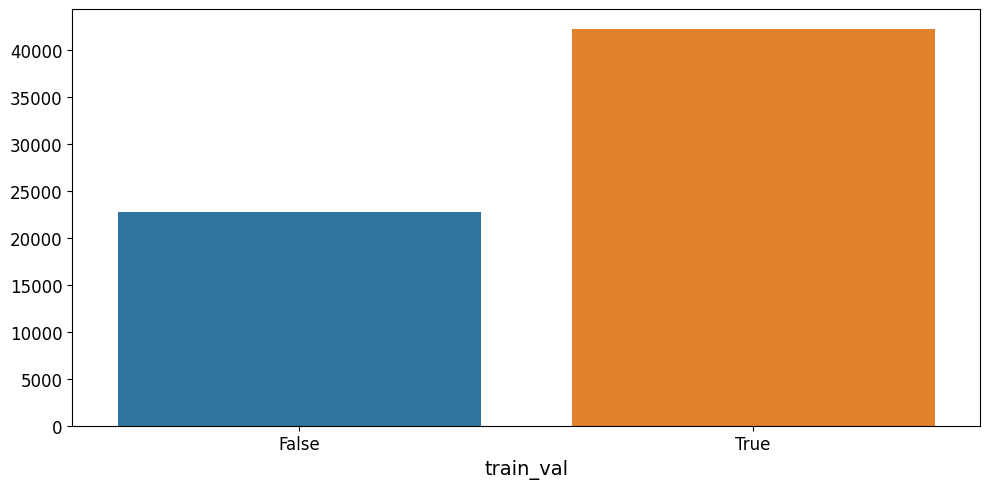

In [173]:
# Check split with a count plot
pl.countplot(sdata_train, vars="train_val", orient="h")

## Training


### Instantiation and initialization
We first need to instantiate and initialize our model, using 'models' module from EUGENe.

In [174]:
from eugene import models

Time to import the updated hybrid model where training parameters were altered and an additional convolutional layer was added. Link to file: https://drive.google.com/file/d/1Og3RB88BNGePkRIm46ubvAHzO9ZHfYHA/view?usp=drive_link

I have this file in the tutorial_configs folder created by the EUGENe tutorial; you can import this using whatever directory you prefer to save it to.

In [175]:
# Download Updated Hybrid Model
# Import Model From Drive

!ls "/content/drive/My Drive/EUGENe/tutorial_configs" # change to personal directory if needed

config = "hybrid.yaml"




cnn.yaml  hybrid.yaml  hyrbid.yaml  updated_hybrid_model  updated_hybrid_model.yaml


Next step uses `load_config` function to load in the new configuration file and initialize the model.

In [176]:

# Load in new configuration
model = models.load_config("tutorial_configs/hybrid.yaml")


In [177]:
# Print out a summary of the model
model.summary()

Model: Hybrid
Sequence length: 170
Output dimension: 1
Task: regression
Loss function: mse_loss
Optimizer: Adam
	Optimizer parameters: {}
	Optimizer starting learning rate: 0.005
Scheduler: ReduceLROnPlateau
	Scheduler parameters: {'patience': 10}
Metric: r2score
	Metric parameters: {}
Seed: None
Parameters summary:


  | Name         | Type    | Params | Mode 
-------------------------------------------------
0 | arch         | Hybrid  | 2.4 M  | train
1 | train_metric | R2Score | 0      | train
2 | val_metric   | R2Score | 0      | train
3 | test_metric  | R2Score | 0      | train
-------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.541     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode

In [143]:
# Initialize the weights
models.init_weights(model)

### Model fitting

Import train module from EUGENe.

In [178]:
from eugene import train

In [179]:
# Train model
train.fit_sequence_module(
    model=model,
    sdata=sdata_train,
    seq_var="ohe_seq",
    target_vars=["enrichment"],
    in_memory=True,
    train_var="train_val",
    epochs=25,
    batch_size=128,
    num_workers=3,
    prefetch_factor=2,
    drop_last=False,
    name="hybrid",
    version="tutorial_model",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)},
    gpus = 1
)

Dropping 0 sequences with NaN targets.
Loading ohe_seq and ['enrichment'] into memory


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/EUGENe/tutorial_logs/hybrid/tutorial_model/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_V

No seed set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_index=True)
/usr/local/lib/python3.10/dist-packages/eugene/plot/_utils.py:321: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_logs = all_logs.append(log, ignore_

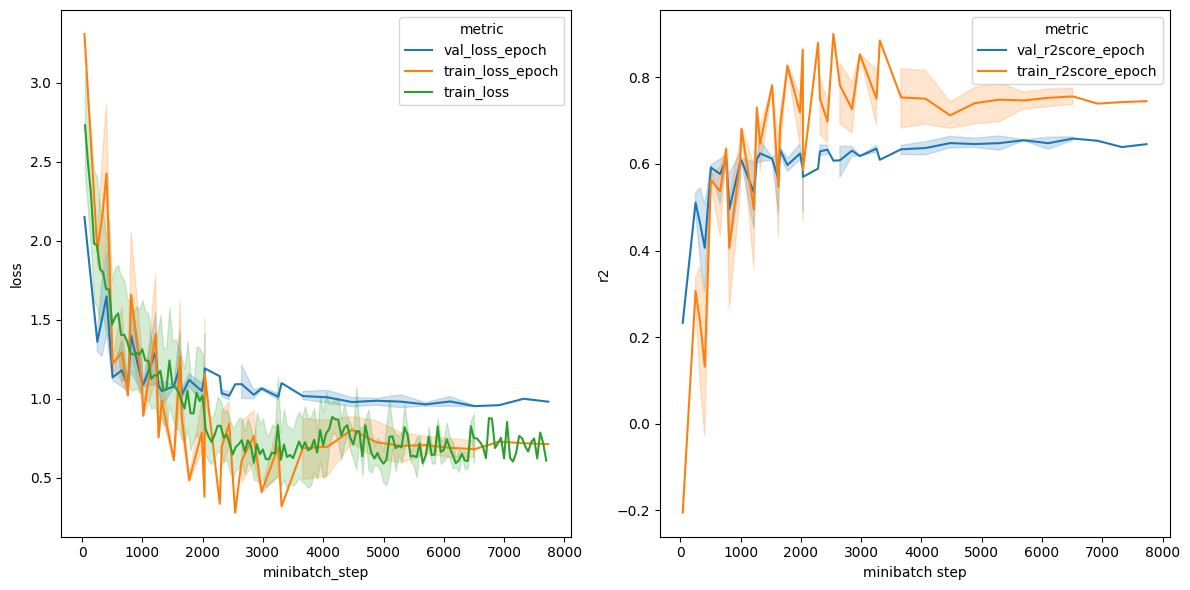

In [180]:
# Plot a loss curve and an r2 curve as a metric
pl.training_summary(os.path.join(settings.logging_dir, "hybrid", "tutorial_model"), metric="r2")

## Evaluation
Uses evaluate module from EUGENe to see how well model works in comparison to the "best model", stored via Pytorch Lightning

In [181]:
from eugene import evaluate

In [182]:
# Import glob to help find the path to the "best" model
import glob

In [183]:
# EUGENe ANNOTATION
# We point to the checkpoints directory within the logging directory to grab the best model
model_file = glob.glob(os.path.join(settings.logging_dir, "hybrid", "tutorial_model", "checkpoints", "*"))[0]
best_model = models.SequenceModule.load_from_checkpoint(model_file, arch=model.arch, strict=False)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['arch.conv1d_tower.layers.15.weight', 'arch.conv1d_tower.layers.15.bias', 'arch.conv1d_tower.layers.19.weight', 'arch.conv1d_tower.layers.19.bias', 'arch.conv1d_tower.layers.19.running_mean', 'arch.conv1d_tower.layers.19.running_var']


In [184]:
# Use this best model to predict on the held-out data. This will store predictions in
evaluate.predictions_sequence_module(
    best_model,
    sdata=sdata_test,
    seq_var="ohe_seq",
    target_vars="enrichment",
    batch_size=2048,
    in_memory=True,
    name="hybrid",
    version="tutorial_model",
    file_label="test",
    prefix=f"tutorial_model_",
    transforms={"ohe_seq": lambda x: x.swapaxes(1, 2)}
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Loading ohe_seq and ['enrichment'] into memory


Predicting: |          | 0/? [00:00<?, ?it/s]

The next part of this code creates a scatter plot comparing the ability of the new model with the "best" one.

Dropping 0 sequences with NaN targets.
Group R2 MSE Pearsonr Spearmanr
At -0.240593975443691 1.7279430949700976 0.11318507098280108
Sb -0.006897862559027468 2.73374572295485 -0.019042058701570733
Zm -0.06460050188783617 3.241545244042516 -0.052683921196425954


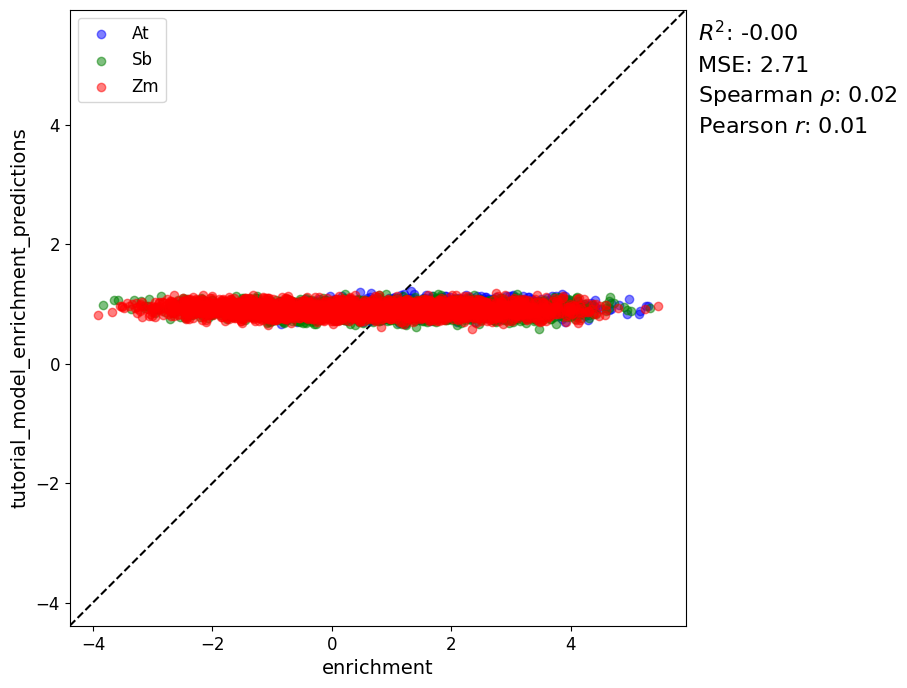

In [185]:
pl.performance_scatter(
    sdata_test,
    target_vars="enrichment",
    prediction_vars="tutorial_model_enrichment_predictions",
    alpha=0.5,
    groupby="sp",
    figsize=(8, 8)
)

###Wow! This model is really really bad. I don't know how the hell my r^2 got to zero when I thought for sure it would increase! In future (i.e., if my life was not as busy and I was able to dedicate more hours than I already have to this), I would investigate the following adjustments: Additional convolutional layers, adding an additional dense layer, and incremental adjustment of the training parameters (optimization, patience, and dropout rate).

---